<a href="https://colab.research.google.com/github/High-ren/Classification/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow_datasets as tfds
import tensorflow as tf


In [ ]:
# Dataset
dataset, info = tfds.load('eurosat', split='train', with_info=True, as_supervised=True)

# Convert tf.data.Dataset to NumPy arrays (X, y)
X = []
y = []
for image, label in tfds.as_numpy(dataset):
    X.append(image)
    y.append(label)

X = np.array(X)
y = np.array(y)
classes = info.features['label'].names


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.3ZY5DK_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
X = X / 255.0  # Normalize pixel values to [0, 1]
y = to_categorical(y, num_classes=len(classes))

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [ ]:
#  CNN Model
def create_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model(len(classes))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [ ]:
# Train the Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=10,
                    callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 253s 370ms/step - accuracy: 0.4917 - loss: 2.0859 - val_accuracy: 0.5324 - val_loss: 1.5632 - learning_rate: 0.0010
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 250s 369ms/step - accuracy: 0.6529 - loss: 1.0151 - val_accuracy: 0.6206 - val_loss: 1.3645 - learning_rate: 0.0010
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 247s 366ms/step - accuracy: 0.6897 - loss: 0.8904 - val_accuracy: 0.3917 - val_loss: 3.1902 - learning_rate: 0.0010
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 236s 350ms/step - accuracy: 0.7154 - loss: 0.8240 - val_accuracy: 0.7311 - val_loss: 0.7927 - learning_rate: 0.0010
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 243s 360ms/step - accuracy: 0.7422 - loss: 0.7628 - val_accuracy: 0.6876 - val_loss: 1.2724 - learning_rate: 0.0010
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 242s 359ms/step - accuracy: 0.7696 - loss: 0.6862 - val_accuracy: 0.8343 - val_loss: 0.4745 - learning_rate: 0.0010
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 255s 348ms/step - accuracy: 0.7800 

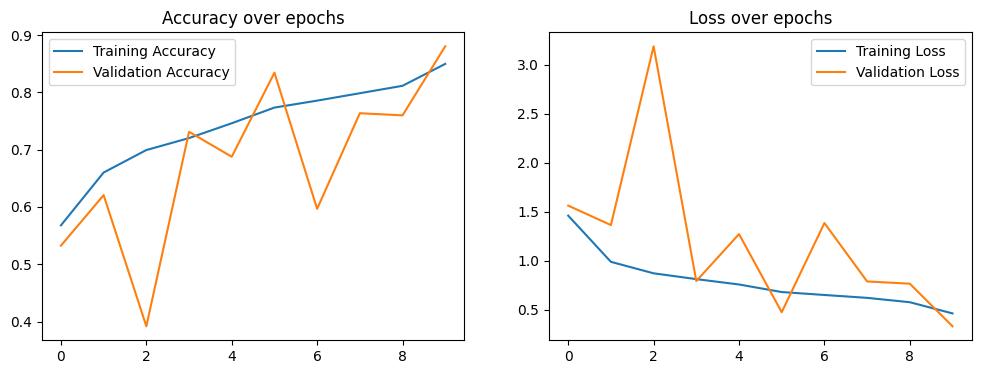

169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step
                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.83      0.87       583
              Forest       0.89      0.99      0.94       598
HerbaceousVegetation       0.85      0.86      0.85       612
             Highway       0.87      0.69      0.77       497
          Industrial       0.93      0.89      0.91       479
             Pasture       0.90      0.89      0.89       389
       PermanentCrop       0.74      0.84      0.79       516
         Residential       0.87      0.99      0.93       592
               River       0.86      0.86      0.86       505
             SeaLake       1.00      0.92      0.96       629

            accuracy                           0.88      5400
           macro avg       0.88      0.88      0.88      5400
        weighted avg       0.88      0.88      0.88      5400



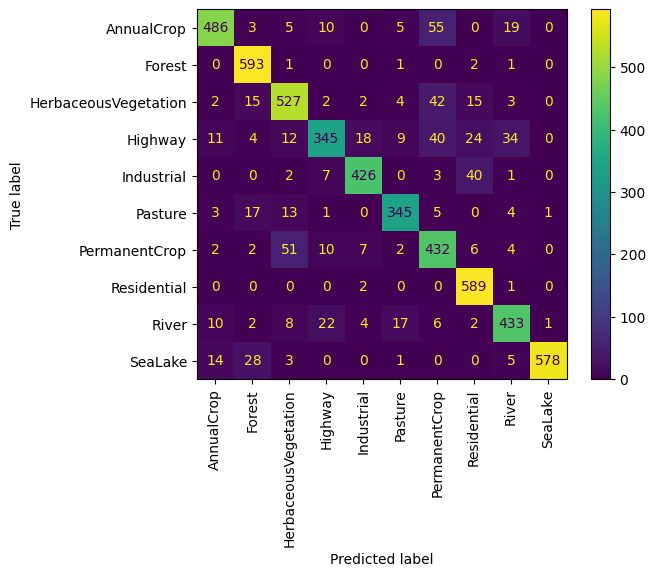

In [ ]:
# Evaluate the Model
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.show()

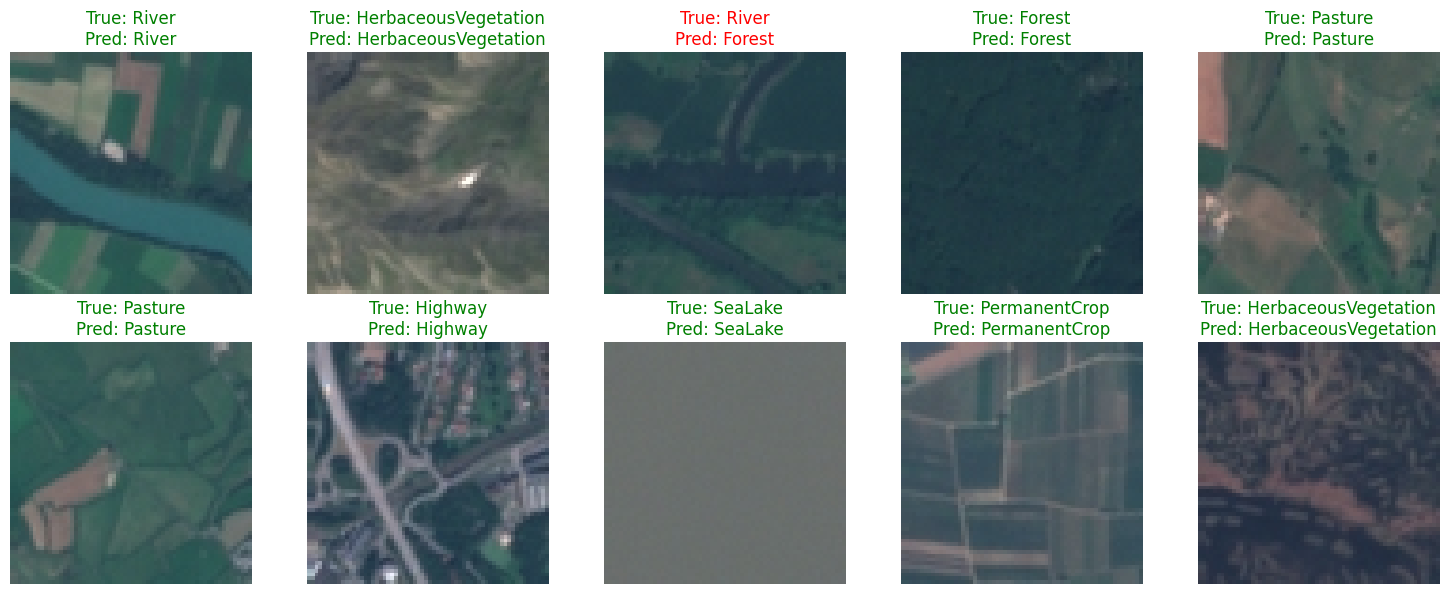

In [ ]:
# Visualize predictions on random test images
num_images = 10  # Number of images to display
random_indices = random.sample(range(len(X_test)), num_images)
selected_images = X_test[random_indices]
selected_true_labels = y_true[random_indices]
selected_pred_labels = y_pred[random_indices]

# Plot images with true & predicted labels
plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.axis("off")
    true_label = classes[selected_true_labels[i]]
    pred_label = classes[selected_pred_labels[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()